In [1]:
%matplotlib inline

# Bokeh for interactive, Seaborn for static

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

sns.set(style="whitegrid", palette="pastel")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from math import pi
import glob

In [2]:
def m_to_cm(x):
    return x * 100
def unit(x):
    return x
def scale_to_rads(x):
    return 20 * x

fsm_map = [
    {'name': 'Wheel Base'        , 'default': 0.08, 'minval': 0.08, 'maxval': 0.16, 'T': m_to_cm},
    {'name': 'Track Width'       , 'default': 0.12, 'minval': 0.08, 'maxval': 0.16, 'T': m_to_cm},
    {'name': 'Wheel Radius'      , 'default': 0.02, 'minval': 0.02, 'maxval': 0.03, 'T': m_to_cm},
    {'name': 'Weg Count'         , 'default': 3   , 'minval': 0   , 'maxval': 7.99, 'T': int  },
    {'name': 'Ext. Slope'        , 'default': 0.5 , 'minval': 0   , 'maxval': 1   , 'T': unit},
    {'name': 'Ext. Intercept'    , 'default': 0.5 , 'minval': 0   , 'maxval': 1   , 'T': unit},
    {'name': 'F. Speed'          , 'default': 1   , 'minval': 0   , 'maxval': 1   , 'T': scale_to_rads},
    {'name': 'F. Left Thresh'    , 'default': 0.17, 'minval': 0   , 'maxval': pi/2, 'T': np.rad2deg},
    {'name': 'F. Right Thresh'   , 'default':-0.17, 'minval':-pi/2, 'maxval': 0   , 'T': np.rad2deg},
    {'name': 'L. Speed Left'     , 'default':-1   , 'minval':-1   , 'maxval': 1   , 'T': scale_to_rads},
    {'name': 'L. Speed Right'    , 'default': 1   , 'minval':-1   , 'maxval': 1   , 'T': scale_to_rads},
    {'name': 'L. Forward Thresh' , 'default': 0.08, 'minval': 0   , 'maxval': pi/2, 'T': np.rad2deg},
    {'name': 'R. Speed Left'     , 'default': 1   , 'minval':-1   , 'maxval': 1   , 'T': scale_to_rads},
    {'name': 'R. Speed Right'    , 'default':-1   , 'minval':-1   , 'maxval': 1   , 'T': scale_to_rads},
    {'name': 'R. Forward Thresh' , 'default':-0.08, 'minval':-pi/2, 'maxval': 0   , 'T': np.rad2deg},
]
fsm_fancy_names = [
    r'WheelBase (cm)',r'TrackWidth (cm)',r'WheelRadius (cm)',r'StrutCount',r'$m_{ext}$ ($\%$)',
    r'$b_{ext}$ ($\%$)',r'F.Speed (rad $s^{-1}$)',r'F.ToLeftThresh ($^\circ$)',
    r'F.ToRightThresh ($^\circ$)',r'L.LeftSpeed (rad $s^{-1}$)',r'L.RightSpeed (rad $s^{-1}$)',
    r'L.ToForwardThresh ($^\circ$)',r'R.LeftSpeed (rad $s^{-1}$)',r'R.RightSpeed (rad $s^{-1}$)',
    r'R.ToForwardThresh ($^\circ$)'
]
for m, n in zip(fsm_map, fsm_fancy_names):
    m['fancy_name'] = n


bnn_map = [
    {'name': 'Wheel Base'        , 'default': 0.08, 'minval': 0.08, 'maxval': 0.16, 'T': m_to_cm},
    {'name': 'Track Width'       , 'default': 0.12, 'minval': 0.08, 'maxval': 0.16, 'T': m_to_cm},
    {'name': 'Wheel Radius'      , 'default': 0.02, 'minval': 0.02, 'maxval': 0.03, 'T': m_to_cm},
    {'name': 'Weg Count'         , 'default': 3   , 'minval': 0   , 'maxval': 7.99, 'T': int  },
    {'name': 'Act. Func.'        , 'default': 0   , 'minval': 0   , 'maxval': 2.99, 'T': int  },
]
bnn_map.extend([{
    'name': 'weight{}'.format(i), 
    'default': 0, 
    'minval': -4, 
    'maxval': 4, 
    'T': float} for i in range(12)])
bnn_fancy_names = [r'WheelBase (cm)',r'TrackWidth (cm)',r'WheelRadius (cm)',r'StrutCount',r'Act.Func.']
bnn_fancy_names += ['Weight {}'.format(widx) for widx in range(12)]
for m, n in zip(bnn_map, bnn_fancy_names):
    m['fancy_name'] = n



def range_transform(x, a, b, c, d):
    return (x - a) * (d - c) / (b - a) + c

In [3]:
fsm0_param_files = '../experiments/fsm-0-1/seed*/outcmaesxrecentbest.dat'
bnn0_param_files = '../experiments/bnn-0-1/seed*/outcmaesxrecentbest.dat'
tws0_param_files = '../experiments/bnn_twist-0-1/seed*/outcmaesxrecentbest.dat'

# fsm_param_files = '../experiments/fsm-30-2/seed*/outcmaesxrecentbest.dat'
# bnn_param_files = '../experiments/bnn-30-2/seed*/outcmaesxrecentbest.dat'

# fsm_param_files = '../experiments/fsm-40-2/seed*/outcmaesxrecentbest.dat'
# bnn_param_files = '../experiments/bnn-40-2/seed*/outcmaesxrecentbest.dat'


def get_data_from_file(glob_dir, header, param_map):
    data = []
    for pop_filepath in sorted(glob.iglob(glob_dir, recursive=True)):
        data.append(pd.read_csv(pop_filepath, comment='%', header=None, names=header, sep=' '))
        data[-1]['fitness'] = (data[-1]['fitness'] * -1) + 1
        for m in param_map:
            data[-1][m['name']] = data[-1][m['name']].apply(
                lambda x: m['T'](range_transform(x, 0, 10, m['minval'], m['maxval'])))
    return data


cmaes_header = ['iter', 'evals', 'sigma', '0', 'fitness']

fsm_header = cmaes_header + [arg['name'] for arg in fsm_map]
fsm_replicates = get_data_from_file(fsm_param_files, fsm_header, fsm_map)
print('Found', len(fsm_replicates), 'data files in', fsm_param_files)

bnn_header = cmaes_header + [arg['name'] for arg in bnn_map]
bnn_replicates = get_data_from_file(bnn_param_files, bnn_header, bnn_map)
print('Found', len(bnn_replicates), 'data files in', bnn_param_files)

# fsm_replicates[0].describe()
# fsm_replicates[0].head()
# bnn_replicates[0].describe()
# bnn_replicates[0].head()

Found 20 data files in ../experiments/fsm-0-1/seed*/outcmaesxrecentbest.dat
Found 20 data files in ../experiments/bnn-0-1/seed*/outcmaesxrecentbest.dat


,iter,evals,sigma,0,fitness,Wheel Base,Track Width,Wheel Radius,Weg Count,Act. Func.,...,weight2,weight3,weight4,weight5,weight6,weight7,weight8,weight9,weight10,weight11
count,1383.000000,1383.000000,1383.000000,1383.0,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,...,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000,1383.000000
mean,692.000000,8304.000000,0.691086,0.0,9.373766,8.584305,10.051985,2.536998,2.501808,1.920463,...,-0.734013,-2.798222,-0.396467,3.398075,2.060129,2.904614,-1.174159,1.104507,-0.681929,-1.374746
std,399.382023,4792.584272,0.363684,0.0,0.959160,0.595132,0.686531,0.405032,1.641041,0.352016,...,1.559603,0.138915,1.618382,0.786279,1.970017,0.896418,2.192882,1.371282,2.322190,1.279082
min,1.000000,12.000000,0.257231,0.0,2.822867,8.000000,8.030233,2.000000,0.000000,0.000000,...,-4.000000,-3.963756,-3.483864,-2.492442,-3.894248,-0.724899,-3.999977,-3.328632,-4.000000,-3.998686
25%,346.500000,4158.000000,0.403391,0.0,9.516667,8.206783,9.707529,2.068342,1.000000,2.000000,...,-1.999851,-2.840390,-1.549712,3.123677,0.326366,2.307117,-3.301722,0.128950,-3.188247,-2.531174
50%,692.000000,8304.000000,0.585533,0.0,9.600000,8.476271,9.942583,2.684021,3.000000,2.000000,...,-0.031375,-2.810405,-0.630850,3.666030,2.894076,3.097015,-1.144037,0.818681,-0.394069,-1.150988
75%,1037.500000,12450.000000,0.873835,0.0,9.640000,8.784291,10.205306,2.957997,4.000000,2.000000,...,0.021134,-2.763083,0.489818,3.917942,3.745017,3.658992,0.597433,2.018803,1.560033,-0.340138
max,1383.000000,16596.000000,2.215614,0.0,9.670000,13.507119,14.148370,3.000000,7.000000,2.000000,...,3.998660,-1.447531,3.999998,4.000000,3.999999,3.999997,3.319051,4.000000,3.996538,3.210748


In [4]:
fsm_replicates_combined = pd.concat(fsm_replicates).reset_index(drop=True)
bnn_replicates_combined = pd.concat(bnn_replicates).reset_index(drop=True)

In [5]:
df_fsm_best = fsm_replicates_combined.nlargest(240, 'fitness').copy()
df_bnn_best = bnn_replicates_combined.nlargest(240, 'fitness').copy()
df_fsm_best.describe()

,iter,evals,sigma,0,fitness,Wheel Base,Track Width,Wheel Radius,Weg Count,Ext. Slope,Ext. Intercept,F. Speed,F. Left Thresh,F. Right Thresh,L. Speed Left,L. Speed Right,L. Forward Thresh,R. Speed Left,R. Speed Right,R. Forward Thresh
count,240.000000,240.000000,240.000000,240.0,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,652.516667,7830.200000,0.565852,0.0,9.690790,8.465117,11.547962,2.993685,5.625000,0.470599,4.015977e-02,19.757320,23.872923,-23.784430,-5.015579,19.654345,30.735652,19.342782,-16.605227,-37.473740
std,379.503209,4554.038512,0.262534,0.0,0.003598,0.440524,0.967670,0.010267,1.719017,0.282836,2.862892e-02,0.372950,4.764566,6.920112,4.043548,0.409089,6.937773,0.761896,2.085010,7.943608
min,68.000000,816.000000,0.255193,0.0,9.686667,8.000008,9.186405,2.927457,0.000000,0.001086,2.871581e-07,17.982967,13.322531,-57.693502,-19.702714,17.938245,12.378507,15.958241,-19.992034,-63.882178
25%,379.250000,4551.000000,0.384280,0.0,9.690000,8.146059,10.896242,2.991676,4.000000,0.233110,1.943479e-02,19.674509,20.423918,-27.077746,-7.362963,19.552041,26.916661,19.012879,-18.394378,-41.669937
50%,576.000000,6912.000000,0.512099,0.0,9.690000,8.358566,11.376328,2.997790,6.000000,0.397681,3.565783e-02,19.911935,23.617456,-22.950752,-4.280215,19.805566,29.755716,19.650650,-16.552653,-36.925764
75%,864.500000,10374.000000,0.640304,0.0,9.693333,8.662258,12.183158,2.999535,7.000000,0.728297,5.760171e-02,19.984938,26.614904,-20.157420,-2.237263,19.946135,33.896855,19.914779,-15.128751,-32.262035
max,1586.000000,19032.000000,1.911048,0.0,9.706500,10.851445,15.810687,3.000000,7.000000,0.997732,1.235373e-01,19.999999,38.475694,-10.492947,4.818010,19.999972,66.182999,19.999995,-9.233144,-15.495968


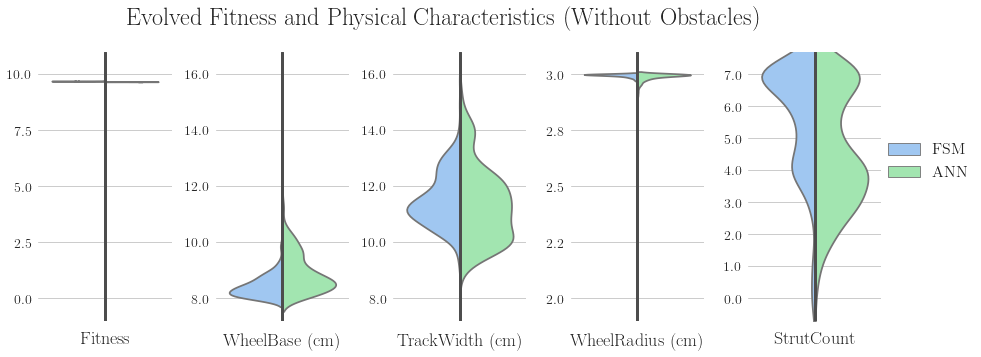

In [19]:
# Physical Characteristics

col_names = ['fitness', 'Wheel Base', 'Track Width', 'Wheel Radius', 'Weg Count']

df_fsm_phys = df_fsm_best[col_names].copy()
df_bnn_phys = df_bnn_best[col_names].copy()
df_fsm_phys['Category'] = 'FSM'
df_bnn_phys['Category'] = 'ANN'
df = pd.concat([df_fsm_phys, df_bnn_phys], keys=['FSM', 'ANN'], axis=0)
df['all'] = ''


col_offset = 5
col_count = 4
col_names = df_fsm_best.columns[col_offset:col_offset + col_count]
ncols = len(col_names) + 1
fsize = ncols * 2.5, 9/2
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=fsize)


for ax, col_name, map_idx in zip(axes, ['fitness'] + list(col_names), range(-1, ncols)):
    if map_idx == -1:
        ymin, ymax = 0, 10
        fancy_name = 'Fitness'
    else:
        m = fsm_map[map_idx]
        ymin, ymax = m['T'](m['minval']), m['T'](m['maxval'])
        fancy_name = m['fancy_name']
    
    # Plot the violin for this parameter
    sns.violinplot(x='all'
                   , y=col_name
                   , data=df
                   , hue='Category'
                   , ax=ax
                   , inner=None
                   , split=True
                   , scale_hue=False
                   , scale='width'
                  )

    # Set the y limits with some padding
    y_padding = (ymax - ymin) * 0.1
    ylims_with_padding = [ymin - y_padding, ymax + y_padding]
    ax.set_ylim(ylims_with_padding)
    
    # Prettify the lines and ticks
    if col_name == 'Weg Count':
        yticks = np.linspace(ymin, ymax, num=ymax + 1)
    else:
        yticks = np.linspace(ymin, ymax, num=5)
    ax.set_yticks(yticks)
    ax.set_yticklabels([round(yval, 1) for yval in yticks], fontsize=14)
    ax.set_xlabel(fancy_name, fontsize=18)
    ax.set_ylabel('')
    
    ax.legend_.remove()
    ax.plot([0, 0], ylims_with_padding, color='0.3', linestyle='-', linewidth=3)
    
sns.despine(top=True, right=True, left=True, bottom=True)
plt.tight_layout()

lgd = axes[-1].legend(loc=(1,0.5), fontsize=16)

ttl = fig.suptitle('Evolved Fitness and Physical Characteristics (Without Obstacles)', 
                   fontsize=24, y=1.1)

# fig.savefig('morph-params.png')
# handles, labels = axes[-1].get_legend_handles_labels()
# lgd = axes[-1].legend(handles, labels, loc=(1, 0.5), fontsize=16)#, bbox_to_anchor=(0.5,-0.1))

# fig.savefig('params1.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
# fig.savefig('params2.png', bbox_extra_artists=(lgd,), bbox_inches='tight')


In [20]:
fig.savefig('../paper/figures/4-results/0-1-best_params.png', 
            bbox_extra_artists=(lgd, ttl), bbox_inches='tight')

In [21]:
def plot_violins(df, col_names, map_offset, violin_size, exp_map):
    col_count = len(col_names)
    df_violin = df[col_names].copy()
    
    figsize = violin_size[0] * col_count, violin_size[1]

    fig, axes = plt.subplots(nrows=1, ncols=col_count, figsize=figsize)

    for ax, col_name, map_idx in zip(axes, col_names, range(map_offset, map_offset + col_count)):
        m = exp_map[map_idx]
        ymin, ymax = m['T'](m['minval']), m['T'](m['maxval'])

        # Plot the violin for this parameter
        sns.violinplot(df_violin[col_name], ax=ax, orient='v')

        # Set the y limits with some padding
        y_padding = (ymax - ymin) * 0.1
        ylims_with_padding = [ymin - y_padding, ymax + y_padding]
        ax.set_ylim(ylims_with_padding)

        # Prettify the lines and ticks
        yticks = np.linspace(ymin, ymax, num=5)
        ax.set_yticks(yticks)
        ax.set_yticklabels([round(yval, 1) for yval in yticks], fontsize=14)
        ax.set_xlabel(m['fancy_name'], fontsize=18)
        ax.set_ylabel('')

    sns.despine(top=True, right=True, left=True, bottom=True)
    plt.tight_layout()
    return fig, axes

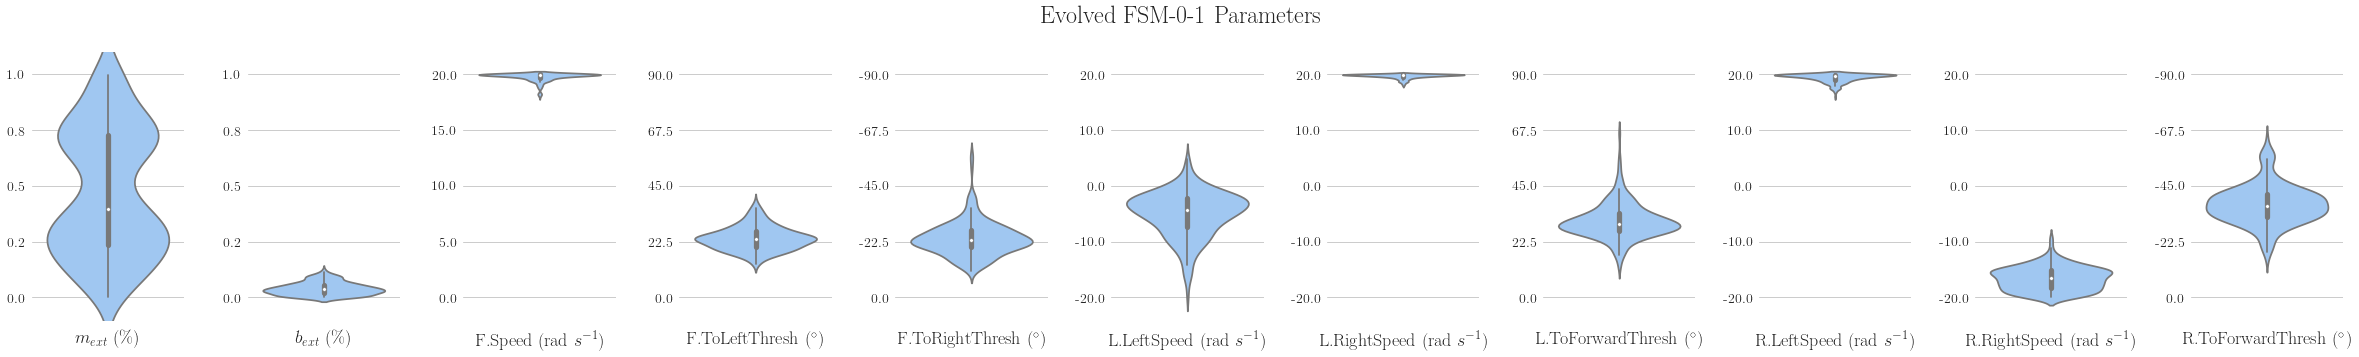

In [28]:
col_start = 9
col_count = 11
figsize = (2.5, 4.5)
col_names = list(df_fsm_best.columns[col_start:col_start + col_count])
fig, axes = plot_violins(df_fsm_best, col_names, col_start - 5, figsize, fsm_map)
axes[4].invert_yaxis()
axes[10].invert_yaxis()

ttl = fig.suptitle('Evolved FSM-0-1 Parameters', fontsize=24, y=1.1)

In [25]:
fig.savefig('../paper/figures/4-results/FSM-0-1-best_params.png', 
            bbox_extra_artists=(ttl,), bbox_inches='tight')

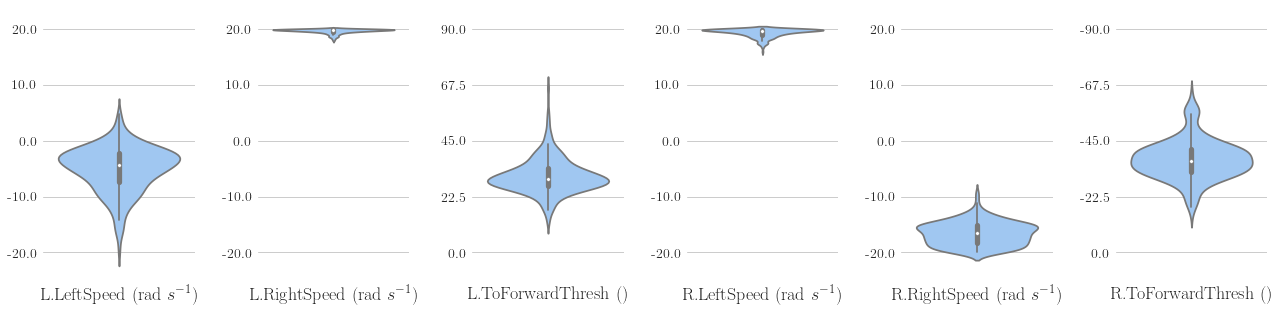

In [217]:
col_start = 14
col_count = 6
col_names = list(df_fsm_best.columns[col_start:col_start + col_count])
fig, axes = plot_violins(df_fsm_best, col_names, col_start - 5, figsize, fsm_map)
axes[5].invert_yaxis()

In [ ]:
fig.savefig('../paper/figures/4-results/FSM-0-1-best_params2.png', 
            bbox_extra_artists=(ttl,), bbox_inches='tight')

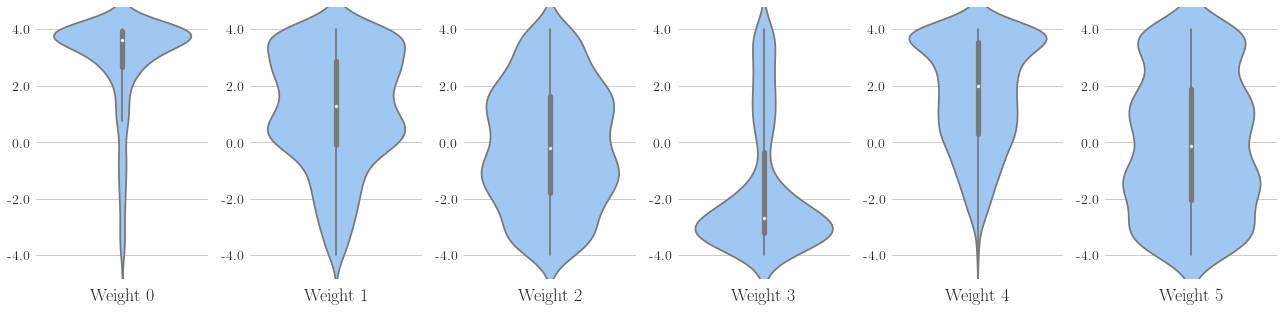

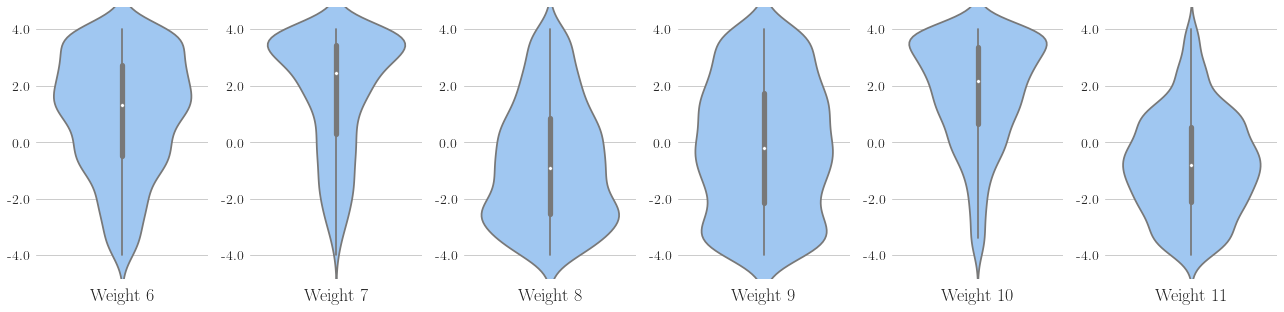

In [179]:
col_start = 10
col_count = 6
col_names = list(df_bnn_best.columns[col_start:col_start + col_count])
fig1, axes1 = plot_violins(df_bnn_best, col_names, col_start - 5, figsize, bnn_map)

col_start = 16
col_count = 6
col_names = list(df_bnn_best.columns[col_start:col_start + col_count])
fig2, axes2 = plot_violins(df_bnn_best, col_names, col_start - 5, figsize, bnn_map)

In [186]:
df_fsm_best.describe()

,iter,evals,sigma,0,fitness,Wheel Base,Track Width,Wheel Radius,Weg Count,Ext. Slope,Ext. Intercept,F. Speed,F. Left Thresh,F. Right Thresh,L. Speed Left,L. Speed Right,L. Forward Thresh,R. Speed Left,R. Speed Right,R. Forward Thresh
count,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,671.000000,8052.000000,0.572895,0.0,9.684896,8.505860,11.699521,2.991852,5.80300,0.450636,4.382033e-02,19.754327,24.515723,-22.901724,-5.551051,19.557879,30.996168,19.262425,-16.708977,-37.199910
std,370.440535,4445.286424,0.267139,0.0,0.004289,0.483091,0.997987,0.012402,1.63489,0.283770,2.830392e-02,0.341616,5.208532,7.556786,4.409964,0.589735,7.387441,0.949659,2.255503,8.557191
min,51.000000,612.000000,0.245233,0.0,9.680000,8.000001,9.186405,2.853960,0.00000,0.001009,2.871581e-07,17.783572,9.164130,-60.380699,-19.702714,15.526238,10.723601,14.000887,-19.998342,-63.882178
25%,391.000000,4692.000000,0.390138,0.0,9.683333,8.158177,11.012356,2.989354,5.00000,0.211666,2.272095e-02,19.640432,20.851445,-26.250941,-7.953091,19.392290,26.847067,18.969936,-18.699736,-41.827477
50%,593.500000,7122.000000,0.512162,0.0,9.683333,8.386722,11.493924,2.996893,7.00000,0.393661,4.044124e-02,19.905355,23.969891,-21.685337,-4.674477,19.765466,30.247484,19.622474,-16.780106,-36.746445
75%,924.750000,11097.000000,0.664819,0.0,9.686667,8.711754,12.372771,2.999364,7.00000,0.699851,6.262078e-02,19.981818,27.915606,-17.942789,-2.539973,19.949020,34.297217,19.920903,-15.138492,-31.696168
max,1586.000000,19032.000000,1.928199,0.0,9.706500,11.279621,15.876401,3.000000,7.00000,0.999976,2.201794e-01,19.999999,41.010230,-6.835558,4.818010,19.999995,66.182999,19.999997,-3.931527,-12.537482
